# Importing packages

In [2671]:
#!c1.8
import pymc as pm
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as pt
import arviz as az
import xarray as xr
az.style.use("arviz-white")
%matplotlib inline


from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.10/dist-packages/pytensor/link/c/exceptions.py:13: UserWarning: You appear to be using an ancient version of setuptools: v51.0.0. Please upgrade to at least v59.0.0. Support for this version of setuptools is provisionary and may be removed without warning in the future.
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data preprocessing

Our data is individual-based surveys which are conducted annually by RLMS. We consider only people who live in Moscow, since we are interested only in discrimination and do not want to model the region effect.

In [2672]:
#!c1.8
data_Moscow = pd.read_csv('observations_Moscow 2022.csv')[['aah5', 'aa_age', 'aaj6.2', 
                                                           'aaj4.1', 'aaj161.3y', 'aa_diplom', 
                                                           'aa_marst', 'aaj13.2', 'aaj262', 'aam20.7', 'aaj1']]

<ipython-input-2-beb5ce8983dd>:1: DtypeWarning: Columns (97,104,106,107,109,110,112,117,118,119,122,154,155,156,158,159,161,163,164,165,167,168,169,170,173,178,180,190,214,216,217,219,220,221,222,236,237,239,247,250,252,254,255,257,264,266,267,269,271,274,277,278,279,280,281,282,283,284,286,287,289,290,301,302,304,339,350,353,356,362,364,375,392,402,403,426,427,439,445,448,449,461,462,483,510,511,512,530,531,532,549,554,555,558,575,584,585,588,589,591,592,594,595,616,622,628,631,640,643,647,663,666,669,673,688,691,703,704,706,707,729) have mixed types. Specify dtype option on import or set low_memory=False.
  data_Moscow = pd.read_csv('observations_Moscow 2022.csv')[['aah5', 'aa_age', 'aaj6.2',
/kernel/lib/python3.10/site-packages/ml_kernel/state/xxhash_changedetector.py:32: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd_types.is_categorical_dtype(df[c].dtype):


In [2673]:
#!c1.8
data_Moscow.columns

Index(['aah5', 'aa_age', 'aaj6.2', 'aaj4.1', 'aaj161.3y', 'aa_diplom',
       'aa_marst', 'aaj13.2', 'aaj262', 'aam20.7', 'aaj1'],
      dtype='object')

In [2674]:
#!c1.8
mapper = {'aah5':'gender',
         'aa_age':'age',
         'aaj6.2':'working time',
         'aaj4.1':'industry',
         'aaj161.3y':'seniority',
          'aa_diplom':'diploma',
         'aa_marst':'married',
         'aaj13.2':'wage',
         'aaj262':'foreign language',
          'aam20.7':'disabled', 
          'aaj1':'employed'
         }
data_Moscow.rename(columns=mapper, inplace=True)
data_Moscow


,gender,age,working time,industry,seniority,diploma,married,wage,foreign language,disabled,employed
0,ЖЕНСКИЙ,66.0,NaN,NaN,39.0,незаконченное среднее образование (7 - 8 кл) +...,Состоите в зарегистрированном браке,NaN,NaN,Нет,Или у Вас сейчас нет работы
1,МУЖСКОЙ,71.0,NaN,NaN,38.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,NaN,NaN,Да,Или у Вас сейчас нет работы
2,ЖЕНСКИЙ,48.0,60.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",15.0,законченное среднее специальное образование,Разведены и в браке не состоите,55000.0,NaN,Нет,Вы сейчас работаете
3,МУЖСКОЙ,22.0,60.0,"ТРАНСПОРТ, СВЯЗЬ",3.0,законченное среднее специальное образование,Никогда в браке не состояли,70000.0,"Можете изъясняться, читаете и переводите со сл...",Нет,Вы сейчас работаете
4,ЖЕНСКИЙ,75.0,NaN,NaN,48.0,законченное среднее специальное образование,Bдовец (вдова),NaN,NaN,Нет,Или у Вас сейчас нет работы
...,...,...,...,...,...,...,...,...,...,...,...
1040,МУЖСКОЙ,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Нет,NaN
1041,ЖЕНСКИЙ,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Нет,NaN
1042,ЖЕНСКИЙ,23.0,NaN,NaN,1.0,законченное среднее образование,Состоите в зарегистрированном браке,NaN,"Можете изъясняться, читаете и переводите со сл...",Нет,Или у Вас сейчас нет работы
1043,ЖЕНСКИЙ,47.0,40.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",29.0,законченное высшее образование и выше,Никогда в браке не состояли,60000.0,NaN,Нет,Вы сейчас работаете


## Data description

- *gender* - gender (0 - male, 1 - female)
- *age* - age (in years)
- *working time* -working time (hours per week, 0 for unemployed)
- *industry* - industry, where a person is employed (categorial variable, utilized TargetEncoding)
- *seniority* - seniority (in years)
- *diploma* - educational stage (categorial variable, utilized TargetEncoding)
- *married* - marital status (categorial variable, utilized TargetEncoding)
- *wage* - wage in rubles (0 for unemployed)
- *foreign language* - the level of foreign language proficiency (categorial variable, utilized TargetEncoding)
- *disabled* - whether a person is disabled (binary variable, 0 -, 1 - disabled)
- *employed* -  whether a person is employed (binary variable, 0 - unemployed, 1 - employed)

## Preprocessing features

In [2675]:
#!c1.8
data_Moscow['gender'].unique()

array(['ЖЕНСКИЙ', 'МУЖСКОЙ'], dtype=object)

In [2676]:
#!c1.8
data_Moscow['gender'] = data_Moscow['gender'].map(lambda x: {'ЖЕНСКИЙ':1, 'МУЖСКОЙ':0}[x])

In [2677]:
#!c1.8
data_Moscow['gender'].unique()

array([1, 0])

### Age

In [2678]:
#!c1.8
data_Moscow['age'].unique()

array([66., 71., 48., 22., 75., 67., 73., 53., 41., 50., 49., 88., 43.,
       62., 35., 61., 64., 60., 33., 79., 58., 42., 59., 85., 37., 55.,
       32., 24., 87., 28., 81., 82., 86., 76., 44., 23., 70., 40., 51.,
       47., 77., 21., 63., 83., 84., 57., 39., 72., 78., 52., 46., 91.,
       26., 34., 19., 30., 74., 80., 18., 54., 69., 68., 92., 56., 38.,
       45., 36., 65., 25., 89., 16., 27., 15., 14., 13., 12., 29., 20.,
       31., 11., 17., 10.,  9.,  8.,  7.,  6.,  5., 93.,  4.,  3.,  2.,
        1.,  0.])

In [2679]:
#!c1.8
data_Moscow = data_Moscow[(data_Moscow['age'] >= 18) & (data_Moscow['age'] <= 65)]
data_Moscow.shape

(622, 11)

In [2680]:
#!c1.8
data_Moscow['age'].unique()

array([48., 22., 53., 41., 50., 49., 43., 62., 35., 61., 64., 60., 33.,
       58., 42., 59., 37., 55., 32., 24., 28., 44., 23., 40., 51., 47.,
       21., 63., 57., 39., 52., 46., 26., 34., 19., 30., 18., 54., 56.,
       38., 45., 36., 65., 25., 27., 29., 20., 31.])

### Wage

In [2681]:
#!c1.8
data_Moscow.loc[data_Moscow['employed'] == 'Или у Вас сейчас нет работы', 'wage'] = 0

In [2682]:
#!c1.8
data_Moscow['wage'].unique()

array(['55000.0', '70000.0', 0, '87000.0', '100000.0', '80000.0',
       '45000.0', '20000.0', '50000.0', '35000.0', nan, '40000.0',
       '110000.0', '85000.0', 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ', '42000.0',
       '52000.0', '128000.0', '200000.0', '95000.0', '47000.0', '15000.0',
       '65000.0', '27000.0', '92000.0', '38000.0', '30000.0', '44000.0',
       '60000.0', '75000.0', '68000.0', '54000.0', '180000.0', '150000.0',
       '250000.0', '12000.0', '28000.0', 'НЕТ ОТВЕТА', '56000.0',
       '22000.0', 'ОТКАЗ ОТ ОТВЕТА', '160000.0', '58000.0', '130000.0',
       '25000.0', '33000.0', '90000.0', '79000.0', '170000.0', '62000.0',
       '23000.0', '98000.0', '31000.0', '43000.0', '32000.0', '155000.0',
       '49000.0', '30500.0', '105000.0', '120000.0', '64000.0', '0.0',
       '48000.0', '38500.0', '63600.0', '34000.0', '16000.0', '37000.0',
       '10000.0', '74000.0', '51000.0', '72000.0', 50000.0, 60000.0],
      dtype=object)

In [2683]:
#!c1.8
wage_drop_condition = ((data_Moscow['wage'] == 'ОТКАЗ ОТ ОТВЕТА') | (data_Moscow['wage'] == 'НЕТ ОТВЕТА') | (data_Moscow['wage'] == 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ') | (data_Moscow['wage'].isna()))
data_Moscow = data_Moscow[wage_drop_condition == False]
data_Moscow.shape

(575, 11)

In [2684]:
#!c1.8
data_Moscow['wage'] = data_Moscow['wage'].astype(float)

In [2685]:
#!c1.8
data_Moscow['wage'].unique()

array([ 55000.,  70000.,      0.,  87000., 100000.,  80000.,  45000.,
        20000.,  50000.,  35000.,  40000., 110000.,  85000.,  42000.,
        52000., 128000., 200000.,  95000.,  47000.,  15000.,  65000.,
        27000.,  92000.,  38000.,  30000.,  44000.,  60000.,  75000.,
        68000.,  54000., 180000., 150000., 250000.,  12000.,  28000.,
        56000.,  22000., 160000.,  58000., 130000.,  25000.,  33000.,
        90000.,  79000., 170000.,  62000.,  23000.,  98000.,  31000.,
        43000.,  32000., 155000.,  49000.,  30500., 105000., 120000.,
        64000.,  48000.,  38500.,  63600.,  34000.,  16000.,  37000.,
        10000.,  74000.,  51000.,  72000.])

### Employed

In [2686]:
#!c1.8
data_Moscow['employed'].unique()

array(['Вы сейчас работаете', 'Или у Вас сейчас нет работы',
       'Вы находитесь в любом другом оплачиваемом отпуске',
       'Вы находитесь в отпуске - декретном или по уходу за ребенком до 3-х лет'],
      dtype=object)

In [2687]:
#!c1.8
job_status_filter = [
    'Вы сейчас работаете',
    'Или у Вас сейчас нет работы'
]

In [2688]:
#!c1.8
data_Moscow = data_Moscow[data_Moscow.employed.isin(job_status_filter)]
data_Moscow.shape

(572, 11)

In [2689]:
#!c1.8
data_Moscow['employed'] = data_Moscow['employed'].map(lambda x: {'Вы сейчас работаете':1, 'Или у Вас сейчас нет работы':0}[x])

In [2690]:
#!c1.8
data_Moscow['employed'].unique()

array([1, 0])

### Working time

In [2691]:
#!c1.8
job_time_filter = [
    'ДРУГОЕ',
    'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ'
]

In [2692]:
#!c1.8
data_Moscow.loc[data_Moscow.employed == 0, 'working time'] = 0

In [2693]:
#!c1.8
data_Moscow['working time'].isna().sum()

0

In [2694]:
#!c1.8
data_Moscow = data_Moscow[data_Moscow['working time'].isin(job_time_filter) == False]

In [2695]:
#!c1.8
data_Moscow['working time'] = data_Moscow['working time'].astype(float)

In [2696]:
#!c1.8
data_Moscow['working time'].unique()

array([60.,  0., 40., 72., 36., 50., 30., 48., 42., 45., 46., 20., 43.,
       24., 18.,  8., 38., 65., 70., 35., 59.,  4., 21., 41., 98., 56.,
       51., 64., 52., 63., 44., 80., 28.])

### Disability

In [2697]:
#!c1.8
data_Moscow['disabled'].unique()

array(['Нет', 'Да', 'ОФОРМЛЯЕТ ДОКУМЕНТЫ'], dtype=object)

In [2698]:
#!c1.8
data_Moscow['disabled'] = data_Moscow['disabled'].map(lambda x: {'ОФОРМЛЯЕТ ДОКУМЕНТЫ':1,'Да':1, 'Нет':0}[x])

In [2699]:
#!c1.8
data_Moscow['disabled'].unique()

array([0, 1])

In [2700]:
#!c1.8
data_Moscow.shape

(549, 11)

### Seniority

In [2701]:
#!c1.8
data_Moscow['seniority']

2       15.0
3        3.0
8       27.0
9       22.0
11       5.0
        ... 
1035     1.0
1037    35.0
1042     1.0
1043    29.0
1044    29.0
Name: seniority, Length: 549, dtype: object

In [2702]:
#!c1.8
data_Moscow['seniority'].unique()

array(['15.0', '3.0', '27.0', '22.0', '5.0', '20.0', '29.0', '33.0',
       '13.0', '44.0', '10.0', '42.0', '19.0', 'НЕТ ОТВЕТА', '40.0',
       '1.0', '16.0', '37.0', '17.0', '36.0', '35.0', '23.0',
       'НЕ БЫЛО СТАЖА', '25.0', 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ', '39.0', '31.0',
       nan, '7.0', '34.0', '30.0', '6.0', '41.0', '32.0', '12.0', '26.0',
       '18.0', '4.0', '24.0', '21.0', '14.0', '9.0', '8.0', '11.0',
       '43.0', '38.0', '28.0', '2.0', '0.0', '45.0', 10.0, 5.0, 40.0, 1.0,
       35.0, 29.0], dtype=object)

In [2703]:
#!c1.8
seniority_drop_condition = ((data_Moscow['seniority'] == 'НЕ БЫЛО СТАЖА') | (data_Moscow['seniority'] == 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ') | (data_Moscow['seniority'] == 'НЕТ ОТВЕТА') | (data_Moscow['seniority'].isna()))
data_Moscow = data_Moscow[seniority_drop_condition == False]
data_Moscow.shape

(490, 11)

In [2704]:
#!c1.8
data_Moscow['seniority'] = data_Moscow['seniority'].astype(float)

In [2705]:
#!c1.8
data_Moscow['seniority']

2       15.0
3        3.0
8       27.0
9       22.0
11       5.0
        ... 
1035     1.0
1037    35.0
1042     1.0
1043    29.0
1044    29.0
Name: seniority, Length: 490, dtype: float64

In [2706]:
#!c1.8
data_Moscow

,gender,age,working time,industry,seniority,diploma,married,wage,foreign language,disabled,employed
2,1,48.0,60.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",15.0,законченное среднее специальное образование,Разведены и в браке не состоите,55000.0,NaN,0,1
3,0,22.0,60.0,"ТРАНСПОРТ, СВЯЗЬ",3.0,законченное среднее специальное образование,Никогда в браке не состояли,70000.0,"Можете изъясняться, читаете и переводите со сл...",0,1
8,1,53.0,0.0,NaN,27.0,законченное среднее образование,Разведены и в браке не состоите,0.0,Владеете свободно,0,0
9,1,41.0,40.0,"НАУКА, КУЛЬТУРА",22.0,законченное высшее образование и выше,Состоите в зарегистрированном браке,87000.0,"Можете изъясняться, читаете и переводите со сл...",0,1
11,0,50.0,72.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",5.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,100000.0,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1035,0,20.0,0.0,NaN,1.0,незаконченное среднее образование (7 - 8 кл) +...,"Живете вместе, но не зарегистрированы",0.0,NaN,0,0
1037,1,50.0,0.0,NaN,35.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,0.0,NaN,0,0
1042,1,23.0,0.0,NaN,1.0,законченное среднее образование,Состоите в зарегистрированном браке,0.0,"Можете изъясняться, читаете и переводите со сл...",0,0
1043,1,47.0,40.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",29.0,законченное высшее образование и выше,Никогда в браке не состояли,60000.0,NaN,0,1


## Categorial variables


In [2707]:
#!c1.8
# Сохраним переменные в изначальном виде
data_industryplot = data_Moscow['industry'].fillna('unknown')
data_diplomaplot = data_Moscow['diploma'].fillna('unknown')
data_marriedplot = data_Moscow['married'].fillna('unknown')
data_foreignplot = data_Moscow['foreign language'].fillna('unknown')

In [2708]:
#!c1.8

cat_features = [
    'industry', 
    'diploma',
    'married',
    'foreign language',
    
]

for feature in cat_features:
    
    print(f'Feature: {feature}')
    
    # Заполняем пропуски в категориях
    data_Moscow[feature] = data_Moscow[feature].fillna('unknown')
    
    # Кодируем
    encoder = TargetEncoder(target_type='continuous')
    encoder.fit(data_Moscow[feature].values.reshape(-1, 1), data_Moscow['wage'].values)
    preds = encoder.transform(data_Moscow[feature].values.reshape(-1, 1))
    
    # Заменяем категории на числа
    data_Moscow[feature] = preds
    
    print(f'Encoded: {data_Moscow[feature].nunique()} categories')

Feature: industry
Encoded: 28 categories
Feature: diploma
Encoded: 5 categories
Feature: married
Encoded: 6 categories
Feature: foreign language
Encoded: 4 categories


## EDA

In [2709]:
#!c1.8
data_Moscow.loc[data_Moscow['working time'] > 0,'hourly wage'] = data_Moscow['wage'] / (4*data_Moscow['working time'])

In [2710]:
#!c1.8
data_cat = data_Moscow.copy()
data_cat['industry'] = data_industryplot 
data_cat['diploma'] = data_diplomaplot 
data_cat['married'] = data_marriedplot 
data_cat['foreign language'] = data_foreignplot 
data_cat

/kernel/lib/python3.10/site-packages/ml_kernel/state/xxhash_changedetector.py:32: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd_types.is_categorical_dtype(df[c].dtype):


,gender,age,working time,industry,seniority,diploma,married,wage,foreign language,disabled,employed,hourly wage
2,1,48.0,60.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",15.0,законченное среднее специальное образование,Разведены и в браке не состоите,55000.0,unknown,0,1,229.166667
3,0,22.0,60.0,"ТРАНСПОРТ, СВЯЗЬ",3.0,законченное среднее специальное образование,Никогда в браке не состояли,70000.0,"Можете изъясняться, читаете и переводите со сл...",0,1,291.666667
8,1,53.0,0.0,unknown,27.0,законченное среднее образование,Разведены и в браке не состоите,0.0,Владеете свободно,0,0,NaN
9,1,41.0,40.0,"НАУКА, КУЛЬТУРА",22.0,законченное высшее образование и выше,Состоите в зарегистрированном браке,87000.0,"Можете изъясняться, читаете и переводите со сл...",0,1,543.750000
11,0,50.0,72.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",5.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,100000.0,unknown,0,1,347.222222
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0,20.0,0.0,unknown,1.0,незаконченное среднее образование (7 - 8 кл) +...,"Живете вместе, но не зарегистрированы",0.0,unknown,0,0,NaN
1037,1,50.0,0.0,unknown,35.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,0.0,unknown,0,0,NaN
1042,1,23.0,0.0,unknown,1.0,законченное среднее образование,Состоите в зарегистрированном браке,0.0,"Можете изъясняться, читаете и переводите со сл...",0,0,NaN
1043,1,47.0,40.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",29.0,законченное высшее образование и выше,Никогда в браке не состояли,60000.0,unknown,0,1,375.000000


In [2711]:
#!c1.8
t = data_Moscow[['gender', 'wage']].groupby(by = 'gender').count()
t / t.sum()

/kernel/lib/python3.10/site-packages/ml_kernel/state/xxhash_changedetector.py:32: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd_types.is_categorical_dtype(df[c].dtype):


,wage
gender,
0,0.391837
1,0.608163


In [2712]:
#!c1.8
t = data_cat[['employed', 'wage']].groupby(by = 'employed').count()
t / t.sum()

,wage
employed,
0,0.373469
1,0.626531


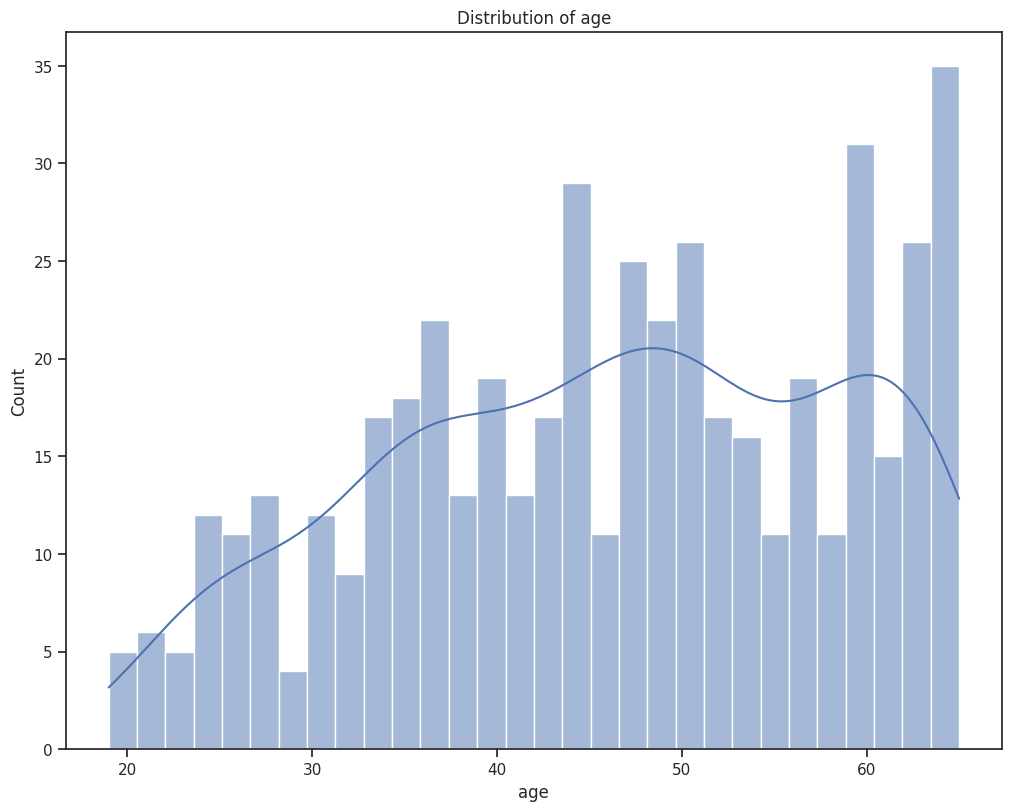

In [2713]:
#!c1.8
sns.set(rc={'figure.figsize':(10,8), 'figure.dpi':100, 'savefig.dpi':100})
sns.set_style("ticks")
sns.histplot(data_Moscow['age'], bins=30,kde=True).set(title = 'Distribution of age')
plt.savefig('age.png')

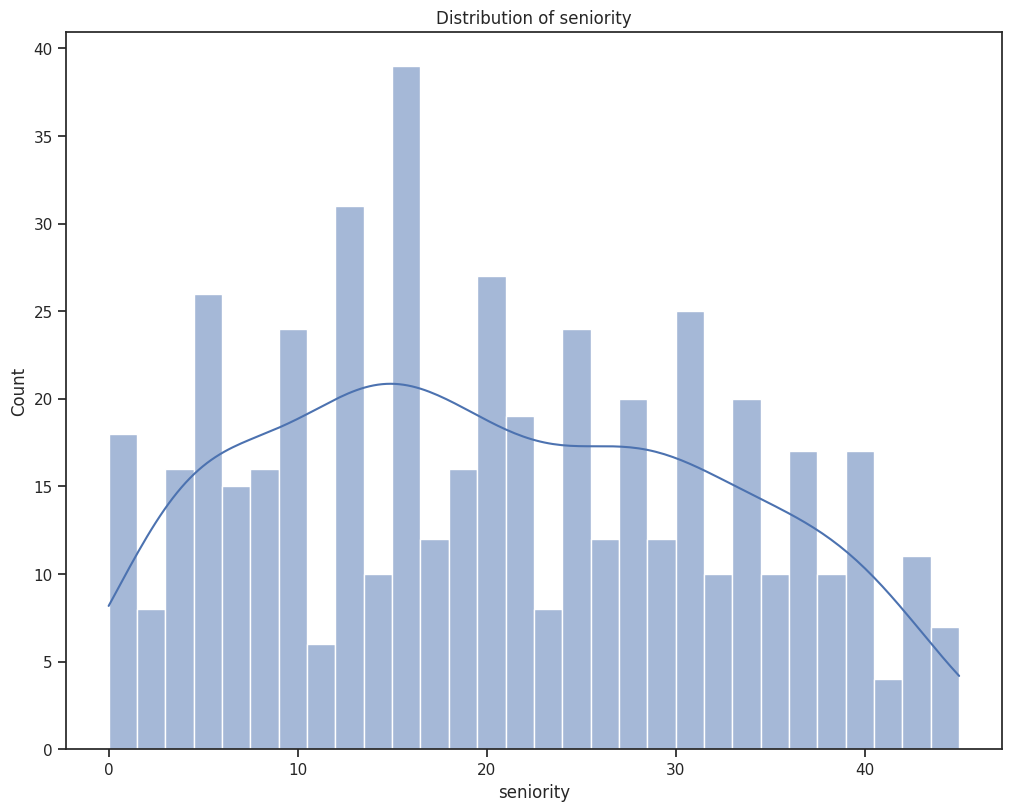

In [2714]:
#!c1.8
sns.set(rc={'figure.figsize':(10,8), 'figure.dpi':100, 'savefig.dpi':100})
sns.set_style("ticks")
sns.histplot(data_Moscow['seniority'], bins=30,kde=True).set(title = 'Distribution of seniority')
plt.savefig('seniority.png')

In [2715]:
#!c1.8
data_cat.diploma.unique()

array(['законченное среднее специальное образование',
       'законченное среднее образование',
       'законченное высшее образование и выше',
       'незаконченное среднее образование (7 - 8 кл) + что-то еще',
       'незаконченное среднее образование (7 - 8 кл)'], dtype=object)

In [2716]:
#!c1.8
data_cat['diploma'] = data_cat['diploma'].fillna('unknown')
data_cat
mapper = {'законченное среднее специальное образование': 'не высшее', 
          'законченное среднее образование':'не высшее', 
          'незаконченное среднее образование (7 - 8 кл) + что-то еще':'не высшее', 
          'незаконченное среднее образование (7 - 8 кл)':'не высшее',
         'законченное высшее образование и выше':'высшее'}
data_cat['diploma'] = data_cat['diploma'].apply(lambda x : mapper[x])
data_cat[['diploma', 'hourly wage']].groupby(by = 'diploma').mean()

,hourly wage
diploma,
высшее,463.240554
не высшее,293.636731


In [2717]:
#!c1.8
data_cat[['diploma', 'hourly wage']].groupby(by = 'diploma').mean()

,hourly wage
diploma,
высшее,463.240554
не высшее,293.636731


In [2718]:
#!c1.8

male_wages = data_cat[data_cat.gender == 0].groupby(['industry'], as_index=False).agg(
    wage_male=('wage', 'mean')
)

female_wages = data_cat[data_cat.gender == 1].groupby(['industry'], as_index=False).agg(
    wage_female=('wage', 'mean'),
    count=('wage', 'count')
)

female_stats = female_wages.sort_values('count', ascending=False).iloc[1:6, :].reset_index(drop=True)
female_stats = female_stats.merge(male_wages, on='industry', how='left').round()
female_stats['wage_diff'] = ((female_stats.wage_female - female_stats.wage_male) / female_stats.wage_male * 100).round(2)
female_stats

/kernel/lib/python3.10/site-packages/ml_kernel/state/xxhash_changedetector.py:32: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd_types.is_categorical_dtype(df[c].dtype):
/kernel/lib/python3.10/site-packages/ml_kernel/state/xxhash_changedetector.py:32: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd_types.is_categorical_dtype(df[c].dtype):
/kernel/lib/python3.10/site-packages/ml_kernel/state/xxhash_changedetector.py:32: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd_types.is_categorical_dtype(df[c].dtype):


,industry,wage_female,count,wage_male,wage_diff
0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",53302.0,48,59767.0,-10.82
1,ОБРАЗОВАНИЕ,59423.0,26,59429.0,-0.01
2,ЗДРАВООХРАНЕНИЕ,73133.0,15,76200.0,-4.02
3,"ТРАНСПОРТ, СВЯЗЬ",44538.0,13,78652.0,-43.37
4,"НАУКА, КУЛЬТУРА",54000.0,10,49571.0,8.93


<ipython-input-49-155c27bd7616>:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])


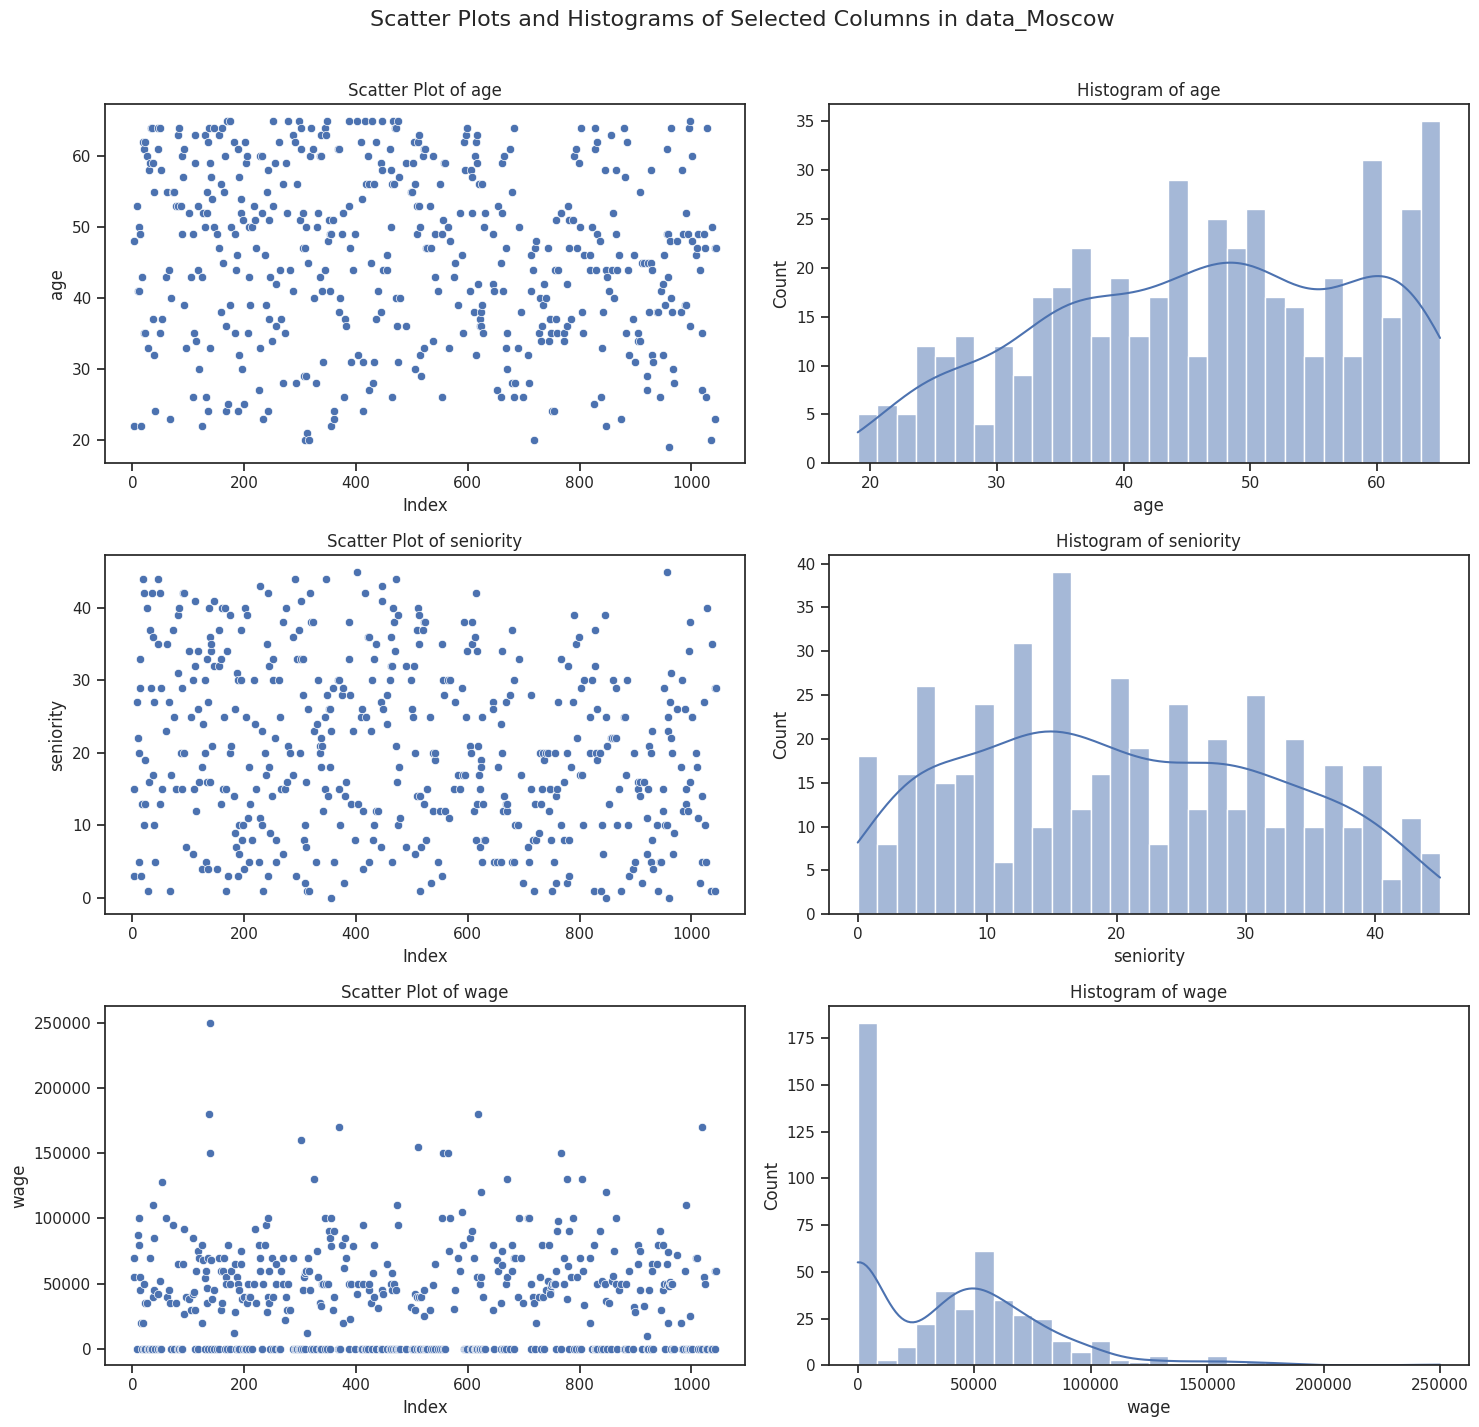

In [2719]:
#!c1.8
selected_cols = ['age', 'working_time', 'seniority', 'wage']

# Ensuring that all selected columns are present in 'data_Moscow'
available_cols = [col for col in selected_cols if col in data_Moscow.columns]

# Creating scatter plots and histograms for the available columns
fig, axes = plt.subplots(len(available_cols), 2, figsize=(15, 5 * len(available_cols)))
fig.suptitle('Scatter Plots and Histograms of Selected Columns in data_Moscow', fontsize=16)

for i, col in enumerate(available_cols):
    # Scatter plot (against index)
    sns.scatterplot(x=data_Moscow.index, y=data_Moscow[col], ax=axes[i, 0])
    axes[i, 0].set_title(f'Scatter Plot of {col}')
    axes[i, 0].set_xlabel('Index')
    axes[i, 0].set_ylabel(col)

    # Histogram
    sns.histplot(data_Moscow[col], bins=30, ax=axes[i, 1], kde=True)
    axes[i, 1].set_title(f'Histogram of {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [ ]:
#!c1.8
selected_columns_part1 = ['diploma', 'industry', 'married', 'foreign language', 'gender', 'disabled', 'employed']
data_part1 = data_Moscow[selected_columns_part1]
data_part1['gender'] = data_part1['gender'].replace({1: 'Female', 0: 'Male'})
data_part1['disabled'] = data_part1['disabled'].replace({1: 'Да', 0: 'Нет'})
data_part1['employed'] = data_part1['employed'].replace({1: 'Есть работа', 0: 'Нет работы'})
data_part1['industry'] = data_industryplot
data_part1['diploma'] = data_diplomaplot
data_part1['married'] = data_marriedplot
data_part1['foreign language'] = data_foreignplot
# Plotting the first set of columns
fig, axes = plt.subplots(len(selected_columns_part1), 2, figsize=(50, 15 * len(selected_columns_part1)))
fig.suptitle('Exploratory Data Analysis - Part 1', fontsize=16)

for i, col in enumerate(selected_columns_part1):
    # If the column is categorical, use a count plot
    if col in data_part1:
        sns.countplot(x=data_part1[col], ax=axes[i, 0])
        axes[i, 0].set_title(f'Count Plot of {col}')
        axes[i, 1].axis('off')  # Turning off the unused plot
    else:
        # Scatter plot (against index) for continuous variables
        sns.scatterplot(x=data_part1.index, y=data_part1[col], ax=axes[i, 0])
        axes[i, 0].set_title(f'Scatter Plot of {col}')
        axes[i, 0].set_ylabel(col)

        # Histogram for continuous variables
        sns.histplot(data_part1[col], bins=30, ax=axes[i, 1], kde=True)
        axes[i, 1].set_title(f'Histogram of {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [2720]:
#!c1.8
target

2        55000.0
3        70000.0
8            0.0
9        87000.0
11      100000.0
          ...   
1035         0.0
1037         0.0
1042         0.0
1043     60000.0
1044     60000.0
Name: wage, Length: 490, dtype: float64

In [2721]:
#!c1.8
data_Moscow['working time']
data_Moscow['hourly wage'] = target
data_Moscow.loc[data_Moscow['working time'] > 0,'hourly wage'] = data_Moscow['wage'] / (4*data_Moscow['working time'])
data_Moscow

,gender,age,working time,industry,seniority,diploma,married,wage,foreign language,disabled,employed,hourly wage
2,1,48.0,60.0,55702.041899,15.0,29827.329028,31110.636312,55000.0,32287.310351,0,1,229.166667
3,0,22.0,60.0,65860.243166,3.0,29827.329028,48018.197240,70000.0,41100.616877,0,1,291.666667
8,1,53.0,0.0,0.000000,27.0,25841.888474,31110.636312,0.0,69462.100703,0,0,0.000000
9,1,41.0,40.0,51902.155154,22.0,53064.592189,40346.971814,87000.0,41100.616877,0,1,543.750000
11,0,50.0,72.0,55702.041899,5.0,29827.329028,40346.971814,100000.0,32287.310351,0,1,347.222222
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0,20.0,0.0,0.000000,1.0,34574.331021,33781.177357,0.0,32287.310351,0,0,0.000000
1037,1,50.0,0.0,0.000000,35.0,29827.329028,40346.971814,0.0,32287.310351,0,0,0.000000
1042,1,23.0,0.0,0.000000,1.0,25841.888474,40346.971814,0.0,41100.616877,0,0,0.000000
1043,1,47.0,40.0,55702.041899,29.0,53064.592189,48018.197240,60000.0,32287.310351,0,1,375.000000


In [2722]:
#!c1.8
target = data_Moscow["wage"]
data_Moscow['working time']
data_Moscow['hourly wage'] = target
data_Moscow.loc[data_Moscow['working time'] > 0,'hourly wage'] = data_Moscow['wage'] / (4*data_Moscow['working time'])
hourly_wage = data_Moscow['hourly wage']
P =  data_Moscow["employed"]
data =  data_Moscow.copy().drop(['wage', 'employed', 'hourly wage'], axis = 1)

non_negative_variables = [
    'gender', 
    'age', 
    'working time', 
    'industry', 
    'seniority', 
    'diploma', 
    'married',  
    'foreign language', 
    'disabled', 
    'employed'
]


#data[non_negative_variables] = np.log1p(data[non_negative_variables])
Y = hourly_wage
Xscaler = StandardScaler()
X = Xscaler.fit_transform(data)

/kernel/lib/python3.10/site-packages/ml_kernel/state/xxhash_changedetector.py:32: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd_types.is_categorical_dtype(df[c].dtype):


In [2723]:
#!c1.8
target = data_Moscow["wage"]

P =  data_Moscow["employed"]
data =  data_Moscow.copy().drop(['wage', 'employed', 'hourly wage'], axis = 1)

non_negative_variables = [
    'gender', 
    'age', 
    'working time', 
    'industry', 
    'seniority', 
    'diploma', 
    'married',  
    'foreign language', 
    'disabled', 
    'employed'
]


#data[non_negative_variables] = np.log1p(data[non_negative_variables])
Y = target
Xscaler = StandardScaler()
X = Xscaler.fit_transform(data)

# Probability model

We implement Bayesian version of Heckman selection model.

In the first step we estimate the probability of labour market participation by regressing the binary variable employed on gender and other control variables. 

In the second step we regress wage on binary variable gender and other control variables. We use Mixture as there are some unemployed, which do not receive any wage. 

## Prior analysis

We introduce Beta prior for $R^2$ with mean of 0.4 in the second model. We anticipate that there is rather substantial noise in the survey. 

In the first step model $R^2$ equals to 1 in some sense. There is no $R^2$ in binary response model. 

In the second step model we implement regression with R2D2 prior. We do in the same way as we have done at our seminar, but there is no Standard Scaling for target(wage).

In both models we impose $\alpha_i$ equal to 2 in Dirichlet distribution for all variables except working time and seniority ($\alpha_i$ equals to 3 for them), as we suppose that they influence more significantly than other variables. 

In Mixture we use LogNormal since wage is non-negative and model 0 with DiracDelta.

σ_prob и σ_wage are positive, thus, we introduce LogNormal for them.

## Model

### Hourly wage 

In [2724]:
#!c1.8
data

,gender,age,working time,industry,seniority,diploma,married,foreign language,disabled
2,1,48.0,60.0,55702.041899,15.0,29827.329028,31110.636312,32287.310351,0
3,0,22.0,60.0,65860.243166,3.0,29827.329028,48018.197240,41100.616877,0
8,1,53.0,0.0,0.000000,27.0,25841.888474,31110.636312,69462.100703,0
9,1,41.0,40.0,51902.155154,22.0,53064.592189,40346.971814,41100.616877,0
11,0,50.0,72.0,55702.041899,5.0,29827.329028,40346.971814,32287.310351,0
...,...,...,...,...,...,...,...,...,...
1035,0,20.0,0.0,0.000000,1.0,34574.331021,33781.177357,32287.310351,0
1037,1,50.0,0.0,0.000000,35.0,29827.329028,40346.971814,32287.310351,0
1042,1,23.0,0.0,0.000000,1.0,25841.888474,40346.971814,41100.616877,0
1043,1,47.0,40.0,55702.041899,29.0,53064.592189,48018.197240,32287.310351,0


In [2524]:
#!c1.8
with pm.Model(coords=dict(
    variable=[*data.columns], 
    variable_wage=[*data.columns, 'λ'],
    observation=range(X.shape[0])
)) as model:
    #1st stage
    intercept_prob = pm.Normal("intercept_prob", 0, 0.2)
    σ_prob = pm.LogNormal("σ_prob", 0, 0.2)
    ϕ_prob = pm.Dirichlet("ϕ_prob", [2]*2 + [3] + [2] + [3] + [2]*4, dims="variable")
    
    β_prob = pm.Normal("β_prob", 0, σ_prob * ϕ_prob ** .5, dims="variable")
    μ_prob = intercept_prob + X @ β_prob
    p = pt.sigmoid(μ_prob)
    
    λ = pt.exp(pm.Normal.logp(X @ β_prob,0, 1) - pm.Normal.logcdf(X @ β_prob, 0, 1)).reshape((-1, 1))
    X_wage = pt.concatenate((X, λ), axis=1)
    
    #2nd stage 
    intercept_wage = pm.Normal("intercept_wage", np.mean(np.log((Y[Y>Y.min()]))), 0.2)
    σ_wage = pm.LogNormal("σ_wage", np.log(np.std(np.log((Y[Y>Y.min()])))), 0.2)
    # variable and regression
    R2_wage = pm.Beta("R2_wage", mu=0.4, sigma=0.08)
    ϕ_wage = pm.Dirichlet("ϕ_wage", [2]*2 + [3]*3 + [2]*5, dims="variable_wage")
    
    model_σ_wage = σ_wage * R2_wage ** .5
    resid_σ_wage = σ_wage * (1 - R2_wage) ** .5
    
    β_wage = pm.Normal("β_wage", 0, model_σ_wage * ϕ_wage ** .5, dims="variable_wage")
    
    μ_wage = intercept_wage + X_wage @ β_wage
    
    components = [pm.DiracDelta.dist(c=0.0), pm.LogNormal.dist(μ_wage, resid_σ_wage)]
    w = pt.stack([1 - p, p], axis=1)
    y = pm.Mixture(name='amount', comp_dists=components, w=w, observed=Y)
model.debug()

point={'intercept_prob': array(0.), 'σ_prob_log__': array(0.02), 'ϕ_prob_simplex__': array([-0.09010336, -0.09010336,  0.31536175, -0.09010336,  0.31536175,
       -0.09010336, -0.09010336, -0.09010336]), 'β_prob': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'intercept_wage': array(10.92788806), 'σ_wage_log__': array(-0.72924777), 'R2_wage_logodds__': array(-0.40546511), 'ϕ_wage_simplex__': array([-0.12163953, -0.12163953,  0.28382558,  0.28382558,  0.28382558,
       -0.12163953, -0.12163953, -0.12163953, -0.12163953]), 'β_wage': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

No problems found



#### Prior predictive check

Sampling: [R2_wage, amount, intercept_prob, intercept_wage, β_prob, β_wage, σ_prob, σ_wage, ϕ_prob, ϕ_wage]


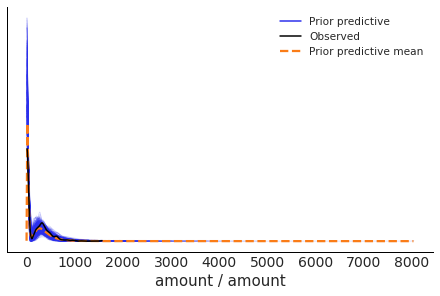

In [2439]:
#!c1.8
with model:
    prior = pm.sample_prior_predictive()
    az.plot_ppc(prior, group = 'prior');

### Monthly wage 

In [2656]:
#!c1.8
#!c1.8
with pm.Model(coords=dict(
    variable=[*data.columns], 
    variable_wage=[*data.columns, 'λ'],
    observation=range(X.shape[0])
)) as model:
    #1st stage
    intercept_prob = pm.Normal("intercept_prob", 0, 0.2)
    σ_prob = pm.LogNormal("σ_prob", 0, 0.2)
    ϕ_prob = pm.Dirichlet("ϕ_prob", [2]*2 + [3] + [2] + [3] + [2]*4, dims="variable")
    
    β_prob = pm.Normal("β_prob", 0, σ_prob * ϕ_prob ** .5, dims="variable")
    μ_prob = intercept_prob + X @ β_prob
    p = pt.sigmoid(μ_prob)
    
    λ = pt.exp(pm.Normal.logp(X @ β_prob,0, 1) - pm.Normal.logcdf(X @ β_prob, 0, 1)).reshape((-1, 1))
    X_wage = pt.concatenate((X, λ), axis=1)
    
    #2nd stage 
    intercept_wage = pm.Normal("intercept_wage", np.mean(np.log((Y[Y>Y.min()]))), 0.05)
    σ_wage = pm.LogNormal("σ_wage", np.log(np.std(np.log((Y[Y>Y.min()])))), 0.1)
    # variable and regression
    R2_wage = pm.Beta("R2_wage", mu=0.4, sigma=0.08)
    ϕ_wage = pm.Dirichlet("ϕ_wage", [2]*2 + [3]*3 + [2]*5, dims="variable_wage")
    
    model_σ_wage = σ_wage * R2_wage ** .5
    resid_σ_wage = σ_wage * (1 - R2_wage) ** .5
    
    β_wage = pm.Normal("β_wage", 0, model_σ_wage * ϕ_wage ** .5, dims="variable_wage")
    
    μ_wage = intercept_wage + X_wage @ β_wage
    
    components = [pm.DiracDelta.dist(c=0.0), pm.LogNormal.dist(μ_wage, resid_σ_wage)]
    w = pt.stack([1 - p, p], axis=1)
    y = pm.Mixture(name='amount', comp_dists=components, w=w, observed=Y)
model.debug()

point={'intercept_prob': array(0.), 'σ_prob_log__': array(0.02), 'ϕ_prob_simplex__': array([-0.09010336, -0.09010336,  0.31536175, -0.09010336,  0.31536175,
       -0.09010336, -0.09010336, -0.09010336]), 'β_prob': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'intercept_wage': array(10.92788806), 'σ_wage_log__': array(-0.74424777), 'R2_wage_logodds__': array(-0.40546511), 'ϕ_wage_simplex__': array([-0.12163953, -0.12163953,  0.28382558,  0.28382558,  0.28382558,
       -0.12163953, -0.12163953, -0.12163953, -0.12163953]), 'β_wage': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

No problems found


#### Prior predictive check

Sampling: [R2_wage, amount, intercept_prob, intercept_wage, β_prob, β_wage, σ_prob, σ_wage, ϕ_prob, ϕ_wage]
<ipython-input-48-e2e326d22e96>:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 432x288 with 0 Axes>

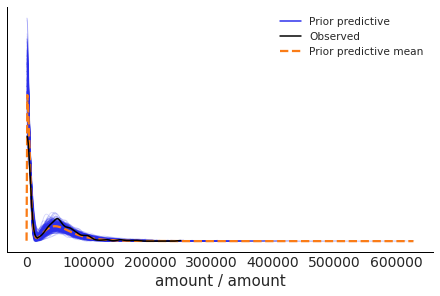

In [2657]:
#!c1.8
with model:
    prior = pm.sample_prior_predictive()
    plt.tight_layout()
    az.plot_ppc(prior, group = 'prior');

В целом, prior predictive довольно хоршеее, мода нашей модели лежит примерно там же, где и данных. 

In [2658]:
#!c1.8
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_prob, σ_prob, ϕ_prob, β_prob, intercept_wage, σ_wage, R2_wage, ϕ_wage, β_wage]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


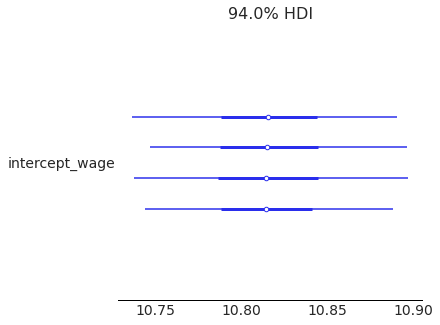

In [2659]:
#!c1.8
az.plot_forest(var_names=['intercept_wage'], data=trace);

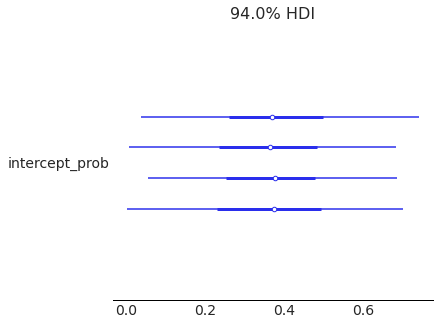

In [2660]:
#!c1.8
az.plot_forest(var_names=['intercept_prob'], data=trace);

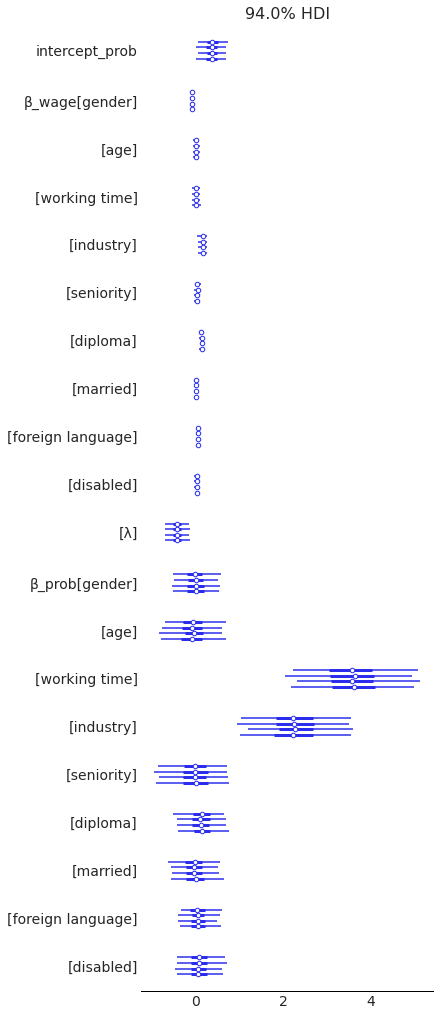

In [2661]:
#!c1.8
az.plot_forest(var_names=['intercept_prob', 'β_wage', 'β_prob',], data=trace);

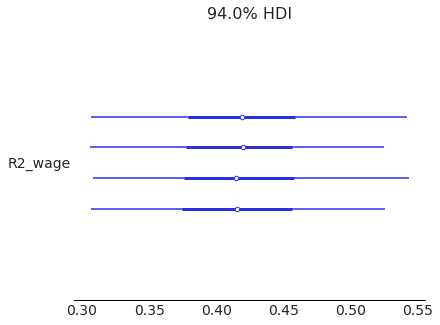

In [2662]:
#!c1.8
az.plot_forest(var_names='R2_wage', data=trace);

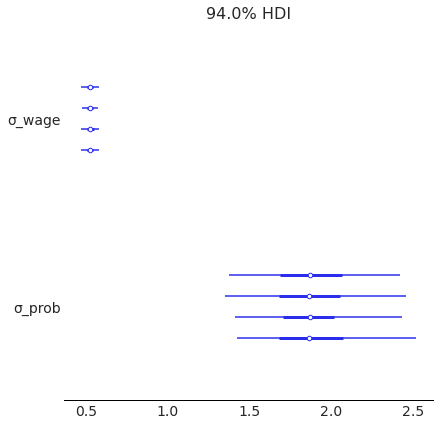

In [2663]:
#!c1.8
az.plot_forest(var_names=['σ_wage', 'σ_prob'], data=trace);

<ipython-input-57-928ae507058a>:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


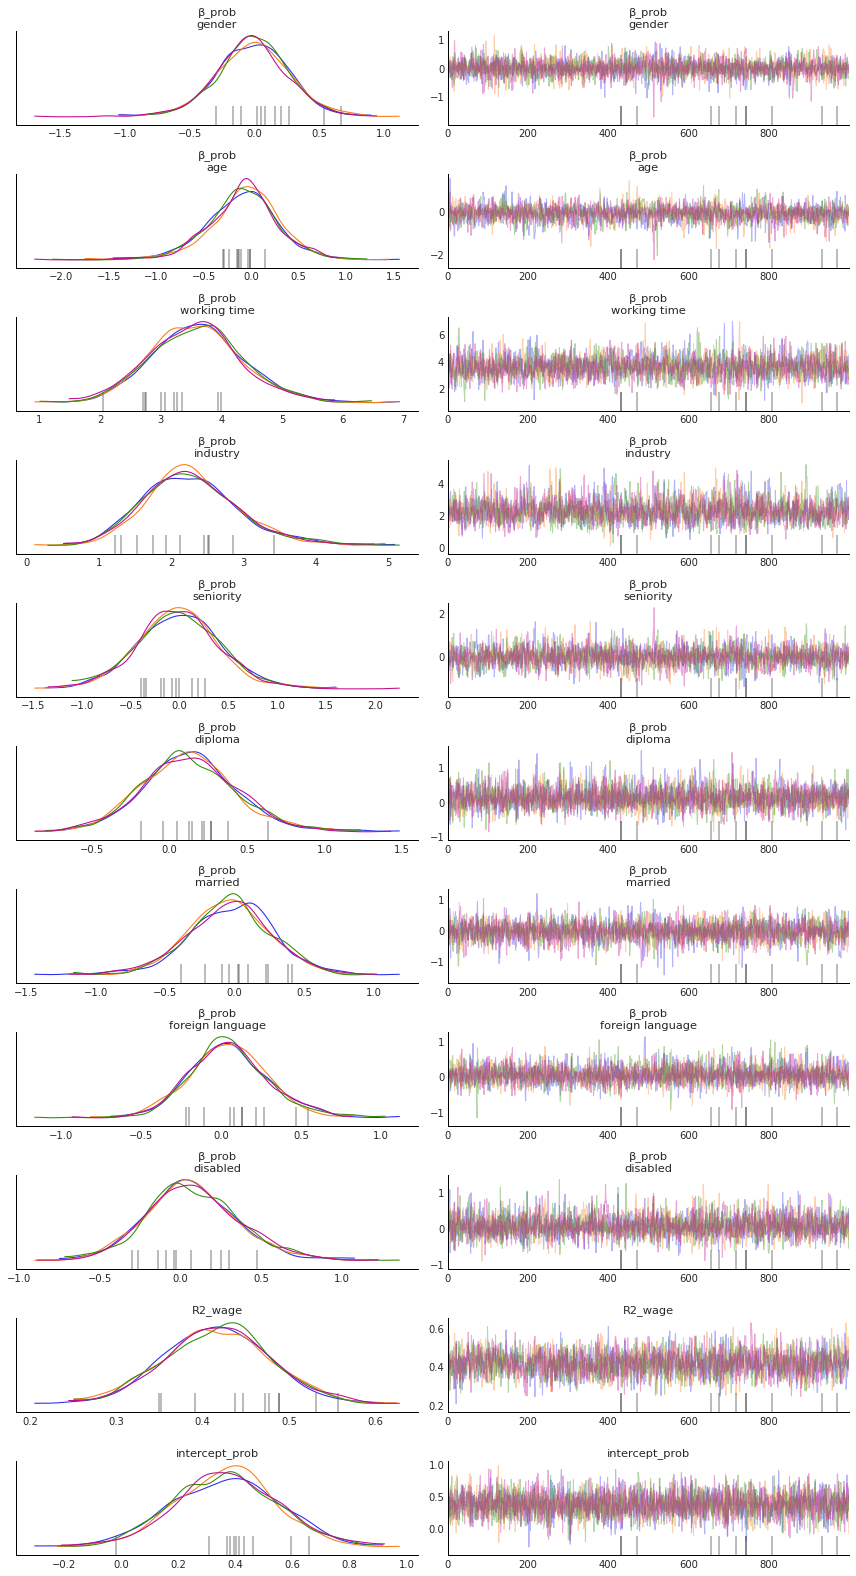

In [2666]:
#!c1.8
az.plot_trace(trace, var_names=['β_prob', 'R2_wage', 'intercept_prob'], compact=False);
plt.tight_layout()
plt.savefig('trace_part_1.png')

<ipython-input-58-c63c9f3a3450>:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


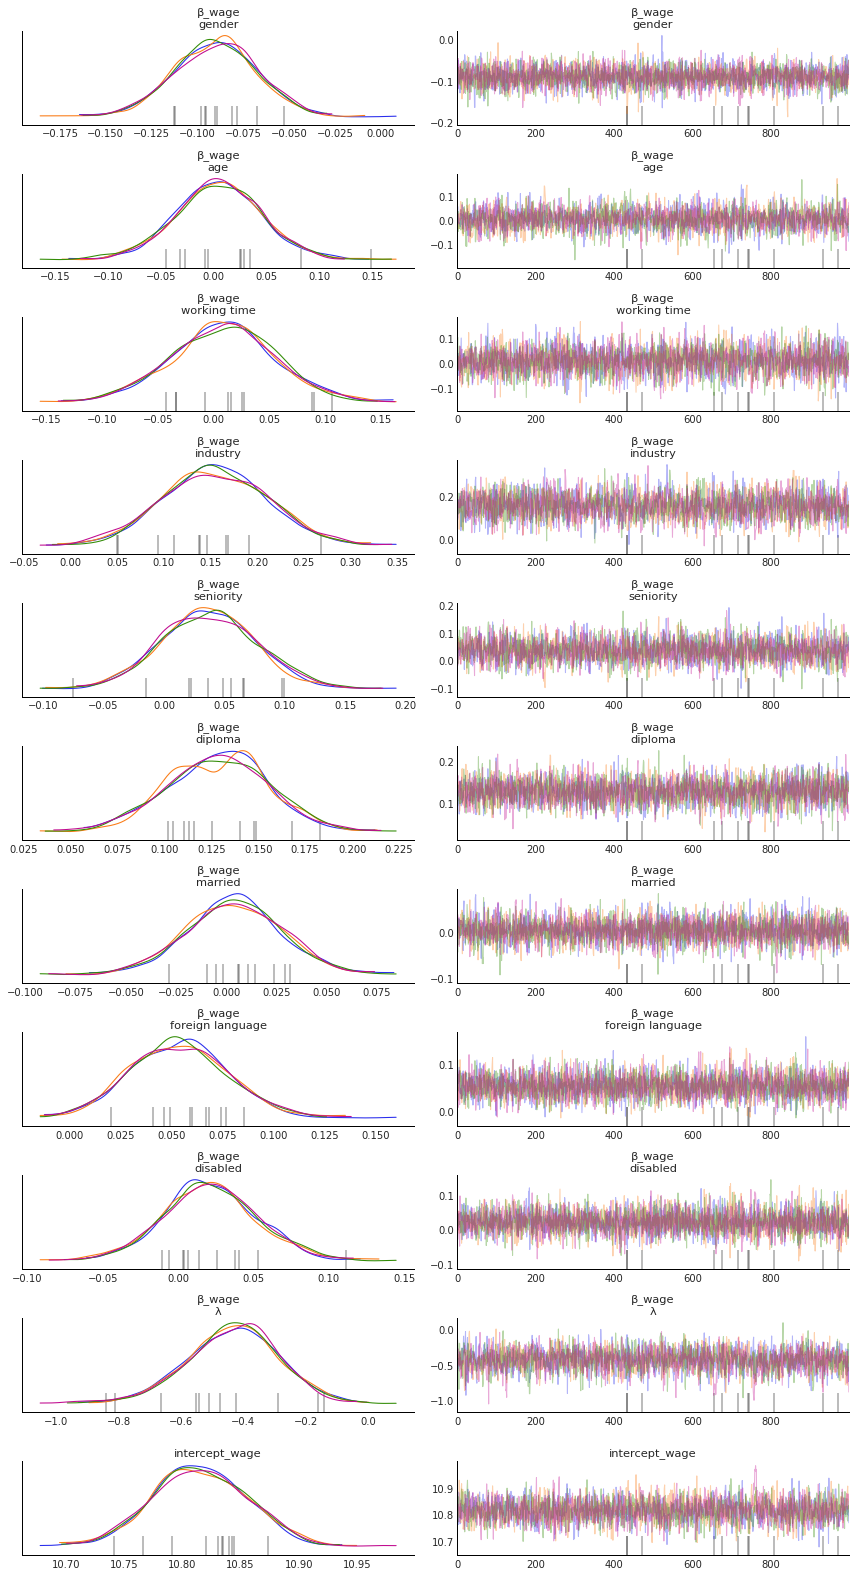

In [2667]:
#!c1.8
az.plot_trace(trace, var_names=['β_wage', 'intercept_wage'], compact=False);
plt.tight_layout()
plt.savefig('trace_part_2.png')

In [ ]:
#!c1.8
obs = pd.read_csv('observations_Moscow 2022.csv')[['aah5', 'aa_age', 'aaj6.2', 
                                                           'aaj4.1', 'aaj161.3y', 'aa_diplom', 
                                                           'aa_marst', 'aaj13.2', 'aaj262', 'aam20.7', 'aaj1']]
obs

In [2451]:
#!c1.8
data_Moscow

,gender,age,working time,industry,seniority,diploma,married,wage,foreign language,disabled,employed,hourly wage
2,1,48.0,60.0,55702.041899,15.0,29827.329028,31110.636312,55000.0,32287.310351,0,1,229.166667
3,0,22.0,60.0,65860.243166,3.0,29827.329028,48018.197240,70000.0,41100.616877,0,1,291.666667
8,1,53.0,0.0,0.000000,27.0,25841.888474,31110.636312,0.0,69462.100703,0,0,0.000000
9,1,41.0,40.0,51902.155154,22.0,53064.592189,40346.971814,87000.0,41100.616877,0,1,543.750000
11,0,50.0,72.0,55702.041899,5.0,29827.329028,40346.971814,100000.0,32287.310351,0,1,347.222222
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0,20.0,0.0,0.000000,1.0,34574.331021,33781.177357,0.0,32287.310351,0,0,0.000000
1037,1,50.0,0.0,0.000000,35.0,29827.329028,40346.971814,0.0,32287.310351,0,0,0.000000
1042,1,23.0,0.0,0.000000,1.0,25841.888474,40346.971814,0.0,41100.616877,0,0,0.000000
1043,1,47.0,40.0,55702.041899,29.0,53064.592189,48018.197240,60000.0,32287.310351,0,1,375.000000


Sampling: [amount]


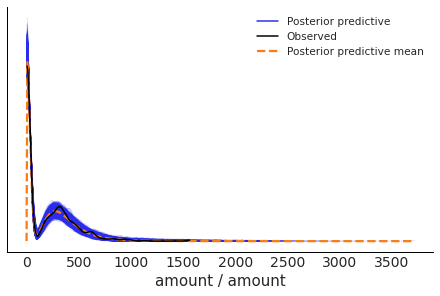

In [2449]:
#!c1.8
with model:
    ppc = pm.sample_posterior_predictive(trace)
    az.plot_ppc(ppc, group = 'posterior');

In [2534]:
#!c1.8
wage_gender_probability = float((trace['posterior']['β_wage'].sel(variable_wage='gender') < 0).mean())
print(f'С вероятностью {wage_gender_probability} на рынке труда есть дискриминация женщин по зарплате, то есть стат. значимо есть дискриминация')

wage_lambda_probability = float((trace['posterior']['β_wage'].sel(variable_wage='λ') < 0).mean())
print(f'С вероятностью {wage_lambda_probability} коэффициент при переменной Хекмана λ < 0.')
print('Это указывает на то, что люди с более высоким потенциалом заработка имеют меньшую вероятность попадания в выборку или что в выборке преобладают индивиды с более низкими доходами.')

wage_lambda_probability = float((trace['posterior']['β_wage'].sel(variable_wage='diploma') > 0).mean())
print(f'С вероятностью {wage_lambda_probability}diploma.')

wage_lambda_probability = float((trace['posterior']['β_wage'].sel(variable_wage='seniority') > 0).mean())
print(f'С вероятностью {wage_lambda_probability} seniority.')


prob_gender_probability = float((trace['posterior']['β_prob'].sel(variable='gender') < 0).mean())
print(f'С вероятностью {prob_gender_probability} на рынке труда есть дискриминация женщин по приёму на работу, то есть мы не можем сказать, что есть дискриминация ')

prob_gender_probability = float((trace['posterior']['β_prob'].sel(variable='foreign language') > 0).mean())
print(f'С вероятностью {prob_gender_probability} эффект от знания языка на зарплату положительный, то есть незначительный эффект от значния иностранного языка')


С вероятностью 0.9995 на рынке труда есть дискриминация женщин по зарплате, то есть стат. значимо есть дискриминация
С вероятностью 0.98475 коэффициент при переменной Хекмана λ < 0.
Это указывает на то, что люди с более высоким потенциалом заработка имеют меньшую вероятность попадания в выборку или что в выборке преобладают индивиды с более низкими доходами.
С вероятностью 1.0diploma.
С вероятностью 0.91775 seniority.
С вероятностью 0.51675 на рынке труда есть дискриминация женщин по приёму на работу, то есть мы не можем сказать, что есть дискриминация 
С вероятностью 0.6915 эффект от знания языка на зарплату положительный, то есть незначительный эффект от значния иностранного языка


In [2454]:
#!c1.8
data_Moscow

,gender,age,working time,industry,seniority,diploma,married,wage,foreign language,disabled,employed,hourly wage
2,1,48.0,60.0,55702.041899,15.0,29827.329028,31110.636312,55000.0,32287.310351,0,1,229.166667
3,0,22.0,60.0,65860.243166,3.0,29827.329028,48018.197240,70000.0,41100.616877,0,1,291.666667
8,1,53.0,0.0,0.000000,27.0,25841.888474,31110.636312,0.0,69462.100703,0,0,0.000000
9,1,41.0,40.0,51902.155154,22.0,53064.592189,40346.971814,87000.0,41100.616877,0,1,543.750000
11,0,50.0,72.0,55702.041899,5.0,29827.329028,40346.971814,100000.0,32287.310351,0,1,347.222222
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0,20.0,0.0,0.000000,1.0,34574.331021,33781.177357,0.0,32287.310351,0,0,0.000000
1037,1,50.0,0.0,0.000000,35.0,29827.329028,40346.971814,0.0,32287.310351,0,0,0.000000
1042,1,23.0,0.0,0.000000,1.0,25841.888474,40346.971814,0.0,41100.616877,0,0,0.000000
1043,1,47.0,40.0,55702.041899,29.0,53064.592189,48018.197240,60000.0,32287.310351,0,1,375.000000


In [2458]:
#!c1.8
data_cat = data_Moscow.copy()
data_cat['industry'] = data_industryplot 
data_cat['diploma'] = data_diplomaplot 
data_cat['married'] = data_marriedplot 
data_cat['foreign language'] = data_foreignplot 
data_cat
data_cat.fillna(value={'diploma':'unknown'})
data_cat.groupby('')

,gender,age,working time,industry,seniority,diploma,married,wage,foreign language,disabled,employed,hourly wage
2,1,48.0,60.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",15.0,законченное среднее специальное образование,Разведены и в браке не состоите,55000.0,unknown,0,1,229.166667
3,0,22.0,60.0,"ТРАНСПОРТ, СВЯЗЬ",3.0,законченное среднее специальное образование,Никогда в браке не состояли,70000.0,"Можете изъясняться, читаете и переводите со сл...",0,1,291.666667
8,1,53.0,0.0,unknown,27.0,законченное среднее образование,Разведены и в браке не состоите,0.0,Владеете свободно,0,0,0.000000
9,1,41.0,40.0,"НАУКА, КУЛЬТУРА",22.0,законченное высшее образование и выше,Состоите в зарегистрированном браке,87000.0,"Можете изъясняться, читаете и переводите со сл...",0,1,543.750000
11,0,50.0,72.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",5.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,100000.0,unknown,0,1,347.222222
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0,20.0,0.0,unknown,1.0,незаконченное среднее образование (7 - 8 кл) +...,"Живете вместе, но не зарегистрированы",0.0,unknown,0,0,0.000000
1037,1,50.0,0.0,unknown,35.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,0.0,unknown,0,0,0.000000
1042,1,23.0,0.0,unknown,1.0,законченное среднее образование,Состоите в зарегистрированном браке,0.0,"Можете изъясняться, читаете и переводите со сл...",0,0,0.000000
1043,1,47.0,40.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",29.0,законченное высшее образование и выше,Никогда в браке не состояли,60000.0,unknown,0,1,375.000000


In [2461]:
#!c1.8
data_cat.

,gender,age,working time,industry,seniority,diploma,married,wage,foreign language,disabled,employed,hourly wage
2,1,48.0,60.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",15.0,законченное среднее специальное образование,Разведены и в браке не состоите,55000.0,unknown,0,1,229.166667
3,0,22.0,60.0,"ТРАНСПОРТ, СВЯЗЬ",3.0,законченное среднее специальное образование,Никогда в браке не состояли,70000.0,"Можете изъясняться, читаете и переводите со сл...",0,1,291.666667
8,1,53.0,0.0,unknown,27.0,законченное среднее образование,Разведены и в браке не состоите,0.0,Владеете свободно,0,0,0.000000
9,1,41.0,40.0,"НАУКА, КУЛЬТУРА",22.0,законченное высшее образование и выше,Состоите в зарегистрированном браке,87000.0,"Можете изъясняться, читаете и переводите со сл...",0,1,543.750000
11,0,50.0,72.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",5.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,100000.0,unknown,0,1,347.222222
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0,20.0,0.0,unknown,1.0,незаконченное среднее образование (7 - 8 кл) +...,"Живете вместе, но не зарегистрированы",0.0,unknown,0,0,0.000000
1037,1,50.0,0.0,unknown,35.0,законченное среднее специальное образование,Состоите в зарегистрированном браке,0.0,unknown,0,0,0.000000
1042,1,23.0,0.0,unknown,1.0,законченное среднее образование,Состоите в зарегистрированном браке,0.0,"Можете изъясняться, читаете и переводите со сл...",0,0,0.000000
1043,1,47.0,40.0,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",29.0,законченное высшее образование и выше,Никогда в браке не состояли,60000.0,unknown,0,1,375.000000


# Recap

1. There is gender disctimination on labour market in Moscow. On average women receive lower wage than men. Nevertheless, the probability of getting a job is equal among men and women ceteris paribus.

2. Sampling bias is detected in our data. We do not observe people, who earn a lot of money, since they do not participate in such surveys.   
